In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [108]:
class FootballDataset(Dataset):
    def __init__(self, feature_cols=None, train=True):
        df = pd.read_csv('gold.csv')
        if feature_cols:
            x = df[feature_cols].values
        else:
            x = df.drop(columns=['team1', 'team2', 'team1_score', 'team1_home', 'team1_nation_team_id_mean',
            'team1_nation_team_id_min', 'team1_nation_team_id_max', 'team2_nation_team_id_mean',
            'team2_nation_team_id_min', 'team2_nation_team_id_max']).values
        y = df['team1_score'].values
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
        self.x = x_train if train else x_test
        self.y = y_train if train else y_test
        self.x = torch.Tensor(self.x)
        self.y = torch.LongTensor(self.y)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, i):
        return self.x[i], self.y[i]

In [109]:
x_cols = ['team1_overall_mean', 'team1_overall_min', 'team1_overall_max',
       'team1_potential_mean', 'team1_potential_min', 'team1_potential_max',
       'team2_overall_mean', 'team2_overall_min', 'team2_overall_max',
       'team2_potential_mean', 'team2_potential_min', 'team2_potential_max',
       'team1_goalkeeping_positioning_max', 'team1_goalkeeping_reflexes_max',
       'team2_goalkeeping_positioning_max', 'team2_goalkeeping_reflexes_max',
       'team1_age_mean', 'team1_age_min', 'team1_age_max','team2_age_mean', 
       'team2_age_min', 'team2_age_max', 'team1_skill_moves_mean',
       'team1_skill_moves_min', 'team1_skill_moves_max', 'team2_skill_moves_mean',
       'team2_skill_moves_min', 'team2_skill_moves_max']
y_cols = ['team1_score']

In [110]:
ds_train = FootballDataset(feature_cols=x_cols)
ds_test = FootballDataset(feature_cols=x_cols, train=False)

In [111]:
dl_train = DataLoader(ds_train, batch_size=64)
dl_test = DataLoader(ds_test, batch_size=64)

In [134]:
class FootballNN(nn.Module):
    def __init__(self, n_input):
        super(FootballNN, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(n_input, 20),
            nn.BatchNorm1d(20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.BatchNorm1d(20),
            nn.Tanh(),
            nn.Linear(20, 15),
            nn.BatchNorm1d(15),
            nn.Tanh(),
            nn.Linear(15, 10),
            nn.BatchNorm1d(10),
            nn.Tanh(),
            nn.Linear(10, 8)
        )

    def forward(self, x):
        return self.main(x)

In [135]:
n_input = ds_train[0][0].shape[0]
model = FootballNN(n_input)

In [146]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (x, y) in enumerate(dataloader):
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return loss.item()

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    return test_loss

In [156]:
learning_rate = 1e-3
epochs = 1000
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [157]:
train_loss_list = []
test_loss_list = []
for t in range(epochs):
    if t % 100 == 0:
        print(f"Epoch {t}")
    l1 = train_loop(dl_train, model, loss_fn, optimizer)
    l2 = test_loop(dl_test, model, loss_fn)
    train_loss_list.append(l1)
    test_loss_list.append(l2)
print("Done!")

Epoch 0
Epoch 100
Epoch 200
Epoch 300
Epoch 400
Epoch 500
Epoch 600
Epoch 700
Epoch 800
Epoch 900
Done!


In [151]:
plt.style.use('seaborn-whitegrid')

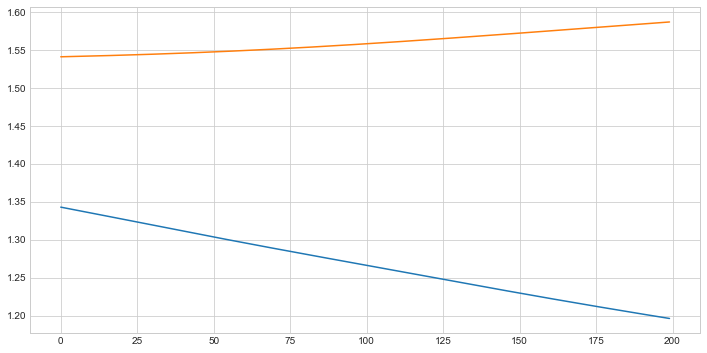

In [153]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train_loss_list)
ax.plot(test_loss_list)

In [139]:
y_pred = nn.Softmax(dim=1)(model(ds_test[:][0])).detach().numpy()

In [140]:
y_pred.argmax(axis=1)

array([2, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 2, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 2, 1, 1, 2,
       0, 1, 2, 1, 0, 0, 1, 1, 0, 2, 1, 0, 0, 0, 2, 0, 1, 1, 0, 0, 1, 1,
       1, 2, 0, 1, 2, 0, 0, 1, 2, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 2,
       0, 2, 2, 1, 0, 1, 1, 1, 2, 0, 1, 0, 2, 1, 2, 1, 2, 1, 0, 1, 1, 1,
       1, 2, 1, 2, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 2, 2, 2, 1, 1, 1, 0, 1,
       0, 2, 1, 2, 0, 1, 1, 2, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 2, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 2, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 2, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 2, 2, 1, 0, 1, 0, 2, 1, 0, 0, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 2, 1, 0, 1, 2, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       2, 1, 2, 1, 1, 1, 2, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 2, 1, 0, 1, 2, 2, 0, 0, 0, 1, 1, 0,